In [1]:
#import necessary libraries

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error
import lightgbm as lgb


In [2]:
#Load the csv data files

offline_sales = pd.read_csv('datasets/sales.csv')
online_sales = pd.read_csv('datasets/online.csv')
actual_matrix = pd.read_csv('datasets/actual_matrix.csv')
discounts_history = pd.read_csv('datasets/discounts_history.csv')
markdowns = pd.read_csv('datasets/markdowns.csv')
price_history = pd.read_csv('datasets/price_history.csv')
stores = pd.read_csv('datasets/stores.csv')
catalog = pd.read_csv('datasets/translated_dataset.csv')

## Data Understanding

Dataset Description
This dataset contains sales information from four stores of one of the retailers over 25 months. Participants are expected to use these files to develop models that can predict customer demand. Additionally, the dataset includes a holdout sample with sales data for a 1-month period for which forecasts should be provided.

1.sales.csv
    Purpose: This file contains aggregated store sales for specific dates.
Columns:
    date: Sales date
    item_id: A unique identifier for each product
    quantity: Total quantity of product sold per day
    price_base: Average sales price per day
    sum_total: Total daily sales amount
    store_id: Store number
online.csv

Purpose: This file contains aggregated online sales by store for specific dates.
Columns:
date: Sales date
item_id: A unique identifier for each product
quantity: Total quantity of product sold per day (online)
price_base: Average sales price per day
sum_total: Total daily sales amount
store_id: Store number
markdowns.csv

Purpose: This file provides data on products sold at markdown prices in each store.
Columns:
date: Date of markdown
item_id: A unique identifier for each product
normal_price: Regular price
price: Price during markdown
quantity: Quantity sold at markdown
store_id: Store number
price_history.csv

Purpose: This file contains price changes data in each store.
Columns:
date: Date of price change
item_id: A unique identifier for each product
price: Item new price
code: Price change code
store_id: Store number
discounts_history.csv

Purpose: Contains historical promo data for each specific store.
Columns:
date: Date
item_id: A unique identifier for each product
sale_price_before_promo: Price before promo period started
sale_price_time_promo: Price during the promo period
promo_type_code: Promo code type
doc_id: Promo document number
number_disc_day: Sequential day number of the current promo period
store_id: Store number
actual_matrix.csv

Purpose: Contains the list of products available in stores.
Columns:
item_id: A unique identifier for each product
date: Date of last product appearance in the current matrix
store_id: Store number
catalog.csv

Purpose: Product catalog with characteristics.
Columns:
item_id: A unique identifier for each product
dept_name: Product department (hierarchy level)
class_name: Product class (hierarchy level)
subclass_name: Product subclass (hierarchy level)
item_type: Product type
weight_volume: Volumetric weight
weight_netto: Net weight
fatness: Fat content
stores.csv

Purpose: Contains stores info data.
Columns:
store_id: Store number
division: Store division
format: Store format
city: Location
area: Store sales area
test.csv

Purpose: Contains the test cases that participants are required to predict.
Columns:
row_id: Unique identifier for each record
item_id: A unique identifier for each product
store_id: Store number
date: The date for which the forecast should be made
sample_submission.csv

Purpose: A sample submission file to demonstrate the expected format for the final submission.
Columns:
row_id: Unique identifier for each record
quantity: The predicted amount for the item. Initially set to 0.

In [3]:
# Basic information about the datasets
def explore_data(df, name):
    print(f"Dataframe: {name}")
    print(df.shape)
    print(df.head())
    print(df.info())
    print("\nSummary Statistics:")
    print(df.describe(include='all'))
    print("Missing Values:\n", df.isnull().sum())
    print("\n\n")

# A for loop to display basic information about the dataframes
dataframes = {"offlinesales": offline_sales, "online_sales":online_sales,"actual_matrix": actual_matrix, "discounts_history": discounts_history, 
              "markdowns": markdowns, "price_history": price_history, "stores": stores, "catalog": catalog}

for name, df in dataframes.items():
    explore_data(df, name)

Dataframe: offlinesales
(7432685, 7)
   Unnamed: 0        date       item_id  quantity  price_base  sum_total  \
0           0  2023-08-04  293375605257     1.000       47.86      47.86   
1           1  2023-08-04  a66fdf2c0ae7     3.000       49.60     148.80   
2           2  2023-08-04  daa46ef49b7a     0.822      379.00     311.54   
3           3  2023-08-04  a3b49c1bf758     1.000      129.00     129.00   
4           4  2023-08-04  ab611c5cef62     7.000       79.90     559.30   

   store_id  
0         1  
1         1  
2         1  
3         1  
4         1  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7432685 entries, 0 to 7432684
Data columns (total 7 columns):
 #   Column      Dtype  
---  ------      -----  
 0   Unnamed: 0  int64  
 1   date        object 
 2   item_id     object 
 3   quantity    float64
 4   price_base  float64
 5   sum_total   float64
 6   store_id    int64  
dtypes: float64(3), int64(2), object(2)
memory usage: 396.9+ MB
None

Summary Statist

## General Observations of the Data
    1.Negative values in the sales columns (quantity, priceBase, sum_total) Action: Drop rows
    2.Covert date column for all dataframes into date_time
    3.introduce a column called source in the sales data
    4.merge online_sales and offline_sales as they have the same column names




In [4]:
# create a function that converts the date columns in the dataframes into datetime.
def convert_date(df, column):
    df[column] = pd.to_datetime(df[column])
    return df

# create a for loop to convert the date columns in the dataframes into datetime
for df in [offline_sales, online_sales, actual_matrix, discounts_history, markdowns, price_history]:
    df = convert_date(df, 'date')

In [5]:
def process_and_merge_sales_data(offline_sales, online_sales):
    # Drop unnecessary column
    offline_sales = offline_sales.drop(columns=["Unnamed: 0"], errors='ignore')
    online_sales = online_sales.drop(columns=["Unnamed: 0"], errors='ignore')

    # Add source column
    offline_sales["source"] = "offline"
    online_sales["source"] = "online"
    
    # Concatenate the datasets
    gold_sales = pd.concat([offline_sales, online_sales], ignore_index=True)
    
    # Remove rows with negative values in specified columns
    gold_sales = gold_sales[(gold_sales["quantity"] > 0) & 
                          (gold_sales["price_base"] > 0) & 
                          (gold_sales["sum_total"] > 0)
    ]

    #Drop NaN values
    gold_sales = gold_sales.dropna()
    
    return gold_sales

In [6]:
#Explore the gold_sales dataset
gold_sales = process_and_merge_sales_data(offline_sales, online_sales)
explore_data(gold_sales, "gold_sales")

Dataframe: gold_sales
(8546887, 7)
        date       item_id  quantity  price_base  sum_total  store_id   source
0 2023-08-04  293375605257     1.000       47.86      47.86         1  offline
1 2023-08-04  a66fdf2c0ae7     3.000       49.60     148.80         1  offline
2 2023-08-04  daa46ef49b7a     0.822      379.00     311.54         1  offline
3 2023-08-04  a3b49c1bf758     1.000      129.00     129.00         1  offline
4 2023-08-04  ab611c5cef62     7.000       79.90     559.30         1  offline
<class 'pandas.core.frame.DataFrame'>
Index: 8546887 entries, 0 to 8556096
Data columns (total 7 columns):
 #   Column      Dtype         
---  ------      -----         
 0   date        datetime64[ns]
 1   item_id     object        
 2   quantity    float64       
 3   price_base  float64       
 4   sum_total   float64       
 5   store_id    int64         
 6   source      object        
dtypes: datetime64[ns](1), float64(3), int64(1), object(2)
memory usage: 521.7+ MB
None

Summary

In [7]:
# import matplotlib.pyplot as plt
# import seaborn as sns
# import pandas as pd

# def visualize_sales_data(gold_sales):
#     # Ensure date column is in datetime format
#     gold_sales['date'] = pd.to_datetime(gold_sales['date'])

#     # Quantity over time per store
#     plt.figure(figsize=(12, 6))
#     sns.lineplot(data=gold_sales, x='date', y='quantity', hue='store_id', estimator='sum', ci=None)
#     plt.title('Quantity Over Time per Store')
#     plt.xlabel('Date')
#     plt.ylabel('Total Quantity')
#     plt.legend(title='Store ID')
#     plt.xticks(rotation=45)
#     plt.grid()
#     plt.show()

#     # Sum of quantity over time (overall)
#     plt.figure(figsize=(12, 6))
#     gold_sales.groupby('date')['quantity'].sum().plot()
#     plt.title('Total Quantity Sold Over Time')
#     plt.xlabel('Date')
#     plt.ylabel('Total Quantity')
#     plt.xticks(rotation=45)
#     plt.grid()
#     plt.show()

#     # Total sum of quantity (single value bar chart removed)
#     total_quantity = gold_sales['quantity'].sum()
#     print(f"Total quantity sold: {total_quantity}")

#     # Price base trend over time
#     plt.figure(figsize=(12, 6))
#     sns.lineplot(data=gold_sales, x='date', y='price_base', ci=None)
#     plt.title('Price Base Over Time')
#     plt.xlabel('Date')
#     plt.ylabel('Price Base')
#     plt.xticks(rotation=45)
#     plt.grid()
#     plt.show()

#     # Quantity and Price Base Relationship
#     plt.figure(figsize=(12, 6))
#     ax = sns.lineplot(data=gold_sales, x='date', y='quantity', label='Total Quantity', color='b')
#     ax2 = ax.twinx()
#     sns.lineplot(data=gold_sales, x='date', y='price_base', ax=ax2, label='Price Base', color='r')

#     ax.set_xlabel('Date')
#     ax.set_ylabel('Total Quantity', color='b')
#     ax2.set_ylabel('Price Base', color='r')
#     plt.title('Quantity vs. Price Base Over Time')
#     ax.tick_params(axis='y', colors='b')
#     ax2.tick_params(axis='y', colors='r')
#     plt.xticks(rotation=45)
#     plt.grid()
#     plt.show()

#     # Top 10 items by total quantity sold
#     top_quantity_items = gold_sales.groupby('item_id')['quantity'].sum().nlargest(10)
#     plt.figure(figsize=(12, 6))
#     sns.barplot(x=top_quantity_items.index, y=top_quantity_items.values, palette="viridis")
#     plt.title('Top 10 Best-Selling Items')
#     plt.xlabel('Item ID')
#     plt.ylabel('Total Quantity Sold')
#     plt.xticks(rotation=45)
#     plt.grid()
#     plt.show()
    
# # Call the function to visualize the data
# visualize_sales_data(gold_sales)


In [8]:
def process_discounts(gold_sales, discounts_history):
    # Drop unnecessary column
    discounts_history = discounts_history.drop(columns=["Unnamed: 0"], errors='ignore')
   
    # Remove rows with negative values in specified columns
    discounts_history = discounts_history[(discounts_history["sale_price_before_promo"] > 0) & 
                          (discounts_history["sale_price_time_promo"] > 0) & 
                          (discounts_history["number_disc_day"] >= 0)
    ]
    #Drop NaN values
    discounts_history = discounts_history.dropna()

    #merge discounts and sales
    gold_sales_discount = pd.merge(gold_sales,discounts_history, on=['date','item_id','store_id'], how='left')
    
    return gold_sales_discount

In [9]:
# Process the discounts and merge with gold_sales
gold_sales_discount = process_discounts(gold_sales, discounts_history)

# Explore the gold_sales_discount dataset
explore_data(gold_sales_discount, "gold_sales_discount")

Dataframe: gold_sales_discount
(8546887, 12)
        date       item_id  quantity  price_base  sum_total  store_id  \
0 2023-08-04  293375605257     1.000       47.86      47.86         1   
1 2023-08-04  a66fdf2c0ae7     3.000       49.60     148.80         1   
2 2023-08-04  daa46ef49b7a     0.822      379.00     311.54         1   
3 2023-08-04  a3b49c1bf758     1.000      129.00     129.00         1   
4 2023-08-04  ab611c5cef62     7.000       79.90     559.30         1   

    source  sale_price_before_promo  sale_price_time_promo  promo_type_code  \
0  offline                      NaN                    NaN              NaN   
1  offline                      NaN                    NaN              NaN   
2  offline                      NaN                    NaN              NaN   
3  offline                      NaN                    NaN              NaN   
4  offline                      NaN                    NaN              NaN   

  doc_id  number_disc_day  
0    NaN     

In [10]:
for col, num_missing in gold_sales_discount.isna().sum().items():
    print(f"{col}:{num_missing} NaN Values")

date:0 NaN Values
item_id:0 NaN Values
quantity:0 NaN Values
price_base:0 NaN Values
sum_total:0 NaN Values
store_id:0 NaN Values
source:0 NaN Values
sale_price_before_promo:6799635 NaN Values
sale_price_time_promo:6799635 NaN Values
promo_type_code:6799635 NaN Values
doc_id:6799635 NaN Values
number_disc_day:6799635 NaN Values


In [11]:
gold = gold_sales_discount.dropna()

In [12]:
# Explore the gold_sales_discount dataset
explore_data(gold, "gold")

Dataframe: gold
(1747252, 12)
         date       item_id  quantity  price_base  sum_total  store_id  \
10 2023-08-04  f0309b5a974b       1.0        59.9       59.9         1   
13 2023-08-04  5f3114373ddd       2.0       449.9      899.8         1   
18 2023-08-04  56edb7bdecaf       2.0       169.9      339.8         1   
30 2023-08-04  034037aebd6e       7.0        99.9      699.3         1   
36 2023-08-04  0780b159bd55       1.0       319.9      319.9         1   

     source  sale_price_before_promo  sale_price_time_promo  promo_type_code  \
10  offline                     79.9                   59.9              6.0   
13  offline                    549.9                  449.9              6.0   
18  offline                    289.9                  219.9              6.0   
30  offline                    109.9                  109.9              6.0   
36  offline                    429.9                  339.9              5.0   

                                  doc_id  nu

In [13]:
#Merging Sales data and PriceHistory

def process_price(gold_sales, price_history):
    # Drop unnecessary column
    price_history = price_history.drop(columns=["Unnamed: 0"], errors='ignore')
   
    # Remove rows with negative values in specified columns
    price_history = price_history[(price_history["price"] > 0) ]
    #Drop NaN values
    price_history = price_history.dropna()

    #merge discounts and sales
    silver = pd.merge(gold_sales,price_history, on=['date','item_id','store_id'], how='left')
    
    return silver

In [14]:
# Process the discounts and merge with gold_sales
silver = process_price(gold_sales, price_history)

# Explore the gold_sales_discount dataset
explore_data(silver, "silver")

Dataframe: silver
(8582201, 9)
        date       item_id  quantity  price_base  sum_total  store_id  \
0 2023-08-04  293375605257     1.000       47.86      47.86         1   
1 2023-08-04  a66fdf2c0ae7     3.000       49.60     148.80         1   
2 2023-08-04  daa46ef49b7a     0.822      379.00     311.54         1   
3 2023-08-04  a3b49c1bf758     1.000      129.00     129.00         1   
4 2023-08-04  ab611c5cef62     7.000       79.90     559.30         1   

    source  price  code  
0  offline    NaN   NaN  
1  offline    NaN   NaN  
2  offline    NaN   NaN  
3  offline    NaN   NaN  
4  offline    NaN   NaN  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8582201 entries, 0 to 8582200
Data columns (total 9 columns):
 #   Column      Dtype         
---  ------      -----         
 0   date        datetime64[ns]
 1   item_id     object        
 2   quantity    float64       
 3   price_base  float64       
 4   sum_total   float64       
 5   store_id    int64         
 6   s

In [15]:
for col, num_missing in silver.isna().sum().items():
    print(f"{col}:{num_missing} NaN Values")

date:0 NaN Values
item_id:0 NaN Values
quantity:0 NaN Values
price_base:0 NaN Values
sum_total:0 NaN Values
store_id:0 NaN Values
source:0 NaN Values
price:8311176 NaN Values
code:8311176 NaN Values


In [16]:
def process_catalog(gold, catalog):
    # Drop unnecessary column
    catalog = catalog.drop(columns=["Unnamed: 0"], errors='ignore')

    #merge catalog and sales
    bronze = pd.merge(gold,catalog[['item_id','dept_name', 'class_name', 'subclass_name']], on='item_id', how='left')
    
    return bronze

In [17]:
# Process the discounts and merge with gold_sales
bronze = process_catalog(gold, catalog)

# Explore the gold_sales_discount dataset
explore_data(bronze, "bronze")

Dataframe: bronze
(1747252, 15)
        date       item_id  quantity  price_base  sum_total  store_id  \
0 2023-08-04  f0309b5a974b       1.0        59.9       59.9         1   
1 2023-08-04  5f3114373ddd       2.0       449.9      899.8         1   
2 2023-08-04  56edb7bdecaf       2.0       169.9      339.8         1   
3 2023-08-04  034037aebd6e       7.0        99.9      699.3         1   
4 2023-08-04  0780b159bd55       1.0       319.9      319.9         1   

    source  sale_price_before_promo  sale_price_time_promo  promo_type_code  \
0  offline                     79.9                   59.9              6.0   
1  offline                    549.9                  449.9              6.0   
2  offline                    289.9                  219.9              6.0   
3  offline                    109.9                  109.9              6.0   
4  offline                    429.9                  339.9              5.0   

                                 doc_id  number_disc_d

In [18]:
for col, num_missing in bronze.isna().sum().items():
    print(f"{col}:{num_missing} NaN Values")

date:0 NaN Values
item_id:0 NaN Values
quantity:0 NaN Values
price_base:0 NaN Values
sum_total:0 NaN Values
store_id:0 NaN Values
source:0 NaN Values
sale_price_before_promo:0 NaN Values
sale_price_time_promo:0 NaN Values
promo_type_code:0 NaN Values
doc_id:0 NaN Values
number_disc_day:0 NaN Values
dept_name:9130 NaN Values
class_name:9130 NaN Values
subclass_name:9130 NaN Values


In [19]:
bronze = bronze.dropna()

In [20]:
for col, num_missing in bronze.isna().sum().items():
    print(f"{col}:{num_missing} NaN Values")

date:0 NaN Values
item_id:0 NaN Values
quantity:0 NaN Values
price_base:0 NaN Values
sum_total:0 NaN Values
store_id:0 NaN Values
source:0 NaN Values
sale_price_before_promo:0 NaN Values
sale_price_time_promo:0 NaN Values
promo_type_code:0 NaN Values
doc_id:0 NaN Values
number_disc_day:0 NaN Values
dept_name:0 NaN Values
class_name:0 NaN Values
subclass_name:0 NaN Values


In [21]:
bronze.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1738122 entries, 0 to 1747251
Data columns (total 15 columns):
 #   Column                   Dtype         
---  ------                   -----         
 0   date                     datetime64[ns]
 1   item_id                  object        
 2   quantity                 float64       
 3   price_base               float64       
 4   sum_total                float64       
 5   store_id                 int64         
 6   source                   object        
 7   sale_price_before_promo  float64       
 8   sale_price_time_promo    float64       
 9   promo_type_code          float64       
 10  doc_id                   object        
 11  number_disc_day          float64       
 12  dept_name                object        
 13  class_name               object        
 14  subclass_name            object        
dtypes: datetime64[ns](1), float64(7), int64(1), object(6)
memory usage: 212.2+ MB


In [44]:
train_data = bronze.copy()

# Feature Engineering

    We aggregate features at different levels (store, item, department, and class) to capture sales trends across multiple hierarchies. 
These aggregations help in understanding demand patterns at various granularities, improving forecast accuracy.
- Store-level: Captures overall store demand fluctuations.
- Item-level: Helps in identifying item-specific trends.
- Department/Class-level: Identifies category-wide trends to capture broader market shifts.

In [23]:
import pandas as pd

def feature_engineering(bronze):
    
    # Ensure data is sorted chronologically
    bronze = bronze.sort_values(['store_id', 'item_id', 'date'])
    
    # Store-level aggregated features
    store_quantity = bronze.groupby(['store_id', 'date'])['quantity'].sum().reset_index().rename(columns={'quantity': 'store_quantity'})
    bronze = bronze.merge(store_quantity, on=['store_id', 'date'], how='left')
    
    # Item-level aggregated features
    item_quantity = bronze.groupby(['item_id', 'date'])['quantity'].sum().reset_index().rename(columns={'quantity': 'item_quantity'})
    bronze = bronze.merge(item_quantity, on=['item_id', 'date'], how='left')
    
    # Product hierarchy aggregates
    dept_quantity = bronze.groupby(['dept_name', 'date'])['quantity'].sum().reset_index().rename(columns={'quantity': 'dept_quantity'})
    bronze = bronze.merge(dept_quantity, on=['dept_name', 'date'], how='left')
    
    class_quantity = bronze.groupby(['class_name', 'date'])['quantity'].sum().reset_index().rename(columns={'quantity': 'class_quantity'})
    bronze = bronze.merge(class_quantity, on=['class_name', 'date'], how='left')
    
    # Promotion features
    bronze['discount_pct'] = ((bronze['price_base'] - bronze['sale_price_time_promo']) / bronze['price_base'] * 100).fillna(0)
    bronze['is_promo'] = (bronze['discount_pct'] > 0).astype(int)
    
    # Time-based features
    bronze['day_of_week'] = bronze['date'].dt.dayofweek
    bronze['is_weekend'] = (bronze['day_of_week'] >= 5).astype(int)
    bronze['month'] = bronze['date'].dt.month
    bronze['quarter'] = bronze['date'].dt.quarter
    
    # Lag features
    lags = [1, 7, 14, 28]
    for lag in lags:
        bronze[f'quantity_lag_{lag}'] = bronze.groupby(['store_id', 'item_id'])['quantity'].shift(lag)
        bronze[f'store_quantity_lag_{lag}'] = bronze.groupby('store_id')['store_quantity'].shift(lag)
        bronze[f'item_quantity_lag_{lag}'] = bronze.groupby('item_id')['item_quantity'].shift(lag)
        bronze[f'price_lag_{lag}'] = bronze.groupby(['store_id', 'item_id'])['price_base'].shift(lag)
        bronze[f'is_promo_lag_{lag}'] = bronze.groupby(['store_id', 'item_id'])['is_promo'].shift(lag)
    
    # Moving averages
    windows = [7, 14, 28]
    for window in windows:
        bronze[f'quantity_ma_{window}d'] = bronze.groupby(['store_id', 'item_id'])['quantity'].transform(lambda x: x.rolling(window, min_periods=1).mean().shift(1))
        bronze[f'store_quantity_ma_{window}d'] = bronze.groupby('store_id')['store_quantity'].transform(lambda x: x.rolling(window, min_periods=1).mean().shift(1))
    
    # Year-over-year features
    bronze['quantity_yoy'] = bronze.groupby(['store_id', 'item_id'])['quantity'].shift(365)
    bronze['quantity_yoy_ma7'] = bronze.groupby(['store_id', 'item_id'])['quantity'].transform(lambda x: x.shift(365).rolling(7, min_periods=1).mean())
    
    # Seasonal trends
    bronze['dow_avg_quantity'] = bronze.groupby(['store_id', 'item_id', 'day_of_week'])['quantity'].transform(lambda x: x.expanding().mean().shift())
    bronze['month_avg_quantity'] = bronze.groupby(['store_id', 'item_id', 'month'])['quantity'].transform(lambda x: x.expanding().mean().shift())
    bronze['quarter_avg_quantity'] = bronze.groupby(['store_id', 'item_id', 'quarter'])['quantity'].transform(lambda x: x.expanding().mean().shift())
    
    # Price-related features
    bronze['price_ratio'] = bronze['sale_price_time_promo'] / bronze['price_base']
    
    # Seasonal indices calculation
    monthly_avg = bronze.groupby(['item_id', 'month'])['quantity'].mean().reset_index()
    overall_avg = bronze.groupby('item_id')['quantity'].mean().reset_index().rename(columns={'quantity': 'overall_avg'})
    seasonal_indices = monthly_avg.merge(overall_avg, on='item_id', how='left')
    seasonal_indices['quantity_seasonal_idx'] = seasonal_indices['quantity'] / seasonal_indices['overall_avg']
    bronze = bronze.merge(seasonal_indices[['item_id', 'month', 'quantity_seasonal_idx']], on=['item_id', 'month'], how='left')
    
    return bronze


In [24]:
# Apply feature engineering
bronze = feature_engineering(bronze)

# Print the head of the bronze dataframe
print(bronze.head())

        date       item_id  quantity  price_base  sum_total  store_id  \
0 2022-12-28  00179dda14f8       1.0       379.1      379.1         1   
1 2022-12-29  00179dda14f8       1.0       499.9      499.9         1   
2 2022-12-31  00179dda14f8       1.0       499.9      499.9         1   
3 2023-01-08  00179dda14f8       1.0       499.9      499.9         1   
4 2023-01-11  00179dda14f8       1.0       499.9      499.9         1   

    source  sale_price_before_promo  sale_price_time_promo  promo_type_code  \
0   online                    599.9                  499.9              5.0   
1  offline                    599.9                  499.9              5.0   
2  offline                    599.9                  499.9              5.0   
3  offline                    599.9                  499.9              5.0   
4  offline                    599.9                  499.9              5.0   

   ... store_quantity_ma_14d  quantity_ma_28d store_quantity_ma_28d  \
0  ...         

In [25]:
def handle_missing_values(bronze):
        
    # Fill missing lags with previous values (forward-fill)
    lag_cols = [col for col in bronze.columns if 'lag' in col]
    bronze[lag_cols] = bronze[lag_cols].fillna(method='ffill')

    # Fill missing moving averages with past values (forward-fill)
    ma_cols = [col for col in bronze.columns if 'ma' in col]
    bronze[ma_cols] = bronze[ma_cols].fillna(method='ffill')

    # Fill seasonal indices with 1 (neutral impact)
    bronze['quantity_seasonal_idx'].fillna(1, inplace=True)

    # Fill price-related NaNs with 1 (neutral multiplier)
    bronze['price_ratio'].fillna(1, inplace=True)
    
    return bronze


In [26]:
bronze = handle_missing_values(bronze)

# Model Building

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead 

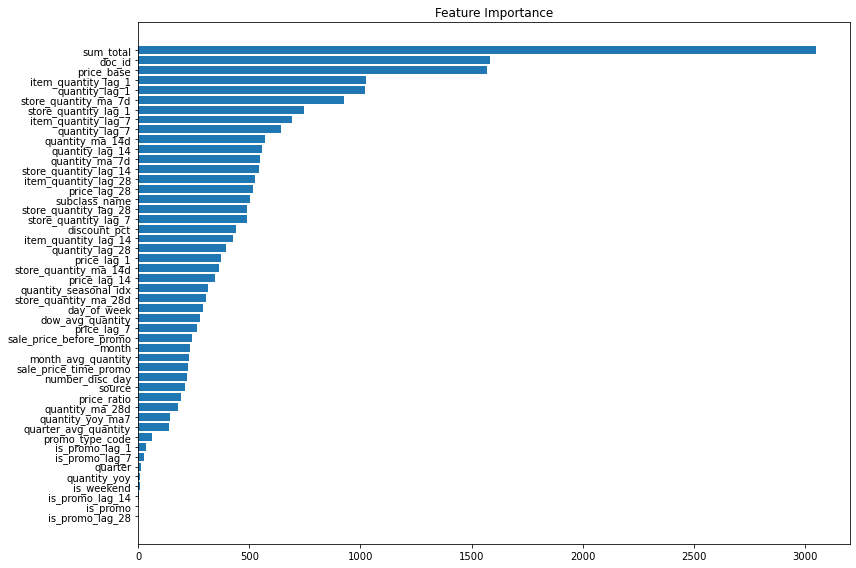

In [ ]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
from lightgbm import early_stopping, log_evaluation
from lightgbm import LGBMRegressor

def train_and_evaluate_model(bronze: pd.DataFrame, target_col: str = 'quantity', exclude_cols: list = None):
    """
    Trains and evaluates a LightGBM model for demand forecasting.
    
    Args:
        bronze (pd.DataFrame): The preprocessed dataframe containing the data.
        target_col (str): The name of the target column. Default is 'quantity'.
        exclude_cols (list): List of columns to exclude from training. Default is None, which excludes common columns.
    
    Returns:
        None: Prints model evaluation results and displays feature importance plot.
    """
    # Default columns to exclude if none are provided
    if exclude_cols is None:
        exclude_cols = [
            'date', 'quantity', 'store_id', 'item_id', 'dept_name', 'class_name',
            'store_quantity', 'item_quantity', 'dept_quantity', 'class_quantity'
        ]
    
    # Convert object columns to category dtype
    for col in ['source', 'doc_id', 'subclass_name']:  
        bronze[col] = bronze[col].astype('category')

    # Get feature columns
    feature_cols = [col for col in bronze.columns if col not in exclude_cols]

    # Handle missing values in features
    for col in feature_cols:
        if bronze[col].dtype in ['int64', 'float64']:  # Only for numeric columns
            bronze[col] = bronze[col].fillna(bronze[col].median())

    # Set up time-based validation
    cutoff_date = bronze['date'].max() - pd.Timedelta(days=28)  # Use last 28 days as validation
    train_data = bronze[bronze['date'] <= cutoff_date]
    valid_data = bronze[bronze['date'] > cutoff_date]

    X_train = train_data[feature_cols]
    y_train = train_data[target_col]
    X_valid = valid_data[feature_cols]
    y_valid = valid_data[target_col]

    # Create LightGBM datasets
    train_dataset = lgb.Dataset(X_train, label=y_train)
    valid_dataset = lgb.Dataset(X_valid, label=y_valid, reference=train_dataset)

    # Set LightGBM parametersaaa
    params = {
        'boosting_type': 'gbdt',
        'objective': 'regression',
        'metric': 'rmse',
        'num_leaves': 31,
        'learning_rate': 0.05,
        'feature_fraction': 0.9,
        'bagging_fraction': 0.8,
        'bagging_freq': 5,
        'verbose': 1
    }

    # Train the model using sklearn API (more version-stable)
    model_sklearn = LGBMRegressor(
        objective='regression',
        metric='rmse',
        num_leaves=31,
        learning_rate=0.05,
        feature_fraction=0.9,
        bagging_fraction=0.8,
        bagging_freq=5,
        n_estimators=1000
    )

    # Fit with early stopping
    model_sklearn.fit(
        X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        eval_metric='rmse',
        callbacks=[early_stopping(50), log_evaluation(50)]  # Controls verbosity
    )

    # Make predictions
    y_pred = model_sklearn.predict(X_valid)

    # Evaluate model performance
    rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
    mae = mean_absolute_error(y_valid, y_pred)

    print(f"Validation RMSE: {rmse:.4f}")
    print(f"Validation MAE: {mae:.4f}")

    # Feature importance analysis
    plt.figure(figsize=(12, 8))
    feature_importance = model_sklearn.feature_importances_
    feature_names = model_sklearn.feature_name_

    # Sort features by importance
    sorted_idx = np.argsort(feature_importance)
    plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx])
    plt.yticks(range(len(sorted_idx)), [feature_cols[i] for i in sorted_idx])
    plt.title('Feature Importance')
    plt.tight_layout()
    plt.show()

# Example usage:
train_and_evaluate_model(bronze)


### Model Training and Testing 

In [45]:
# Model Testing on test.csv dataset and monitor performance and generate submission file.

train_data.columns

Index(['date', 'item_id', 'quantity', 'price_base', 'sum_total', 'store_id',
       'source', 'sale_price_before_promo', 'sale_price_time_promo',
       'promo_type_code', 'doc_id', 'number_disc_day', 'dept_name',
       'class_name', 'subclass_name'],
      dtype='object')

In [46]:
test_data = pd.read_csv('datasets/test.csv', sep=';')

In [48]:
train_data['date'] = pd.to_datetime(train_data['date'])
test_data['date'] = pd.to_datetime(test_data['date'])
train_data.sort_values(by='date', inplace=True)

In [49]:
test_data.head()

,row_id,item_id,store_id,date
0,0,c578da8e8841,1,2024-09-27
1,1,c578da8e8841,1,2024-09-28
2,2,c578da8e8841,1,2024-09-29
3,3,c578da8e8841,1,2024-09-30
4,4,c578da8e8841,1,2024-10-01


In [51]:
bronze_features = ['item_id', 'quantity', 'store_id', 'date']
train_data = bronze[bronze_features]

In [62]:
test_features = ['item_id', 'store_id', 'date']
test_data = test_data[test_features]

In [63]:
# Reset indices to ensure uniqueness
train_data = train_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)   

In [64]:
# If quantity is missing in the test dataset
if 'quantity' not in test_data.columns:
    test_data['quantity'] = np.nan
    
# Concatenate training and test data
combined = pd.concat([train_data, test_data], sort=False)

In [65]:
# For feature computation, fill forward the last known quantity from training
# This makes sure that when computing lag/rolling features for test rows,
# they can pick up historical values from the training period
combined['quantity'] = combined['quantity'].fillna(method='ffill')

In [66]:
import pandas as pd

def feature_engineering(bronze):
    
    # Ensure data is sorted chronologically
    bronze = bronze.sort_values(['store_id', 'item_id', 'date'])
    
    # Store-level aggregated features
    store_quantity = bronze.groupby(['store_id', 'date'])['quantity'].sum().reset_index().rename(columns={'quantity': 'store_quantity'})
    bronze = bronze.merge(store_quantity, on=['store_id', 'date'], how='left')
    
    # Item-level aggregated features
    item_quantity = bronze.groupby(['item_id', 'date'])['quantity'].sum().reset_index().rename(columns={'quantity': 'item_quantity'})
    bronze = bronze.merge(item_quantity, on=['item_id', 'date'], how='left')
    
    # Time-based features
    bronze['day_of_week'] = bronze['date'].dt.dayofweek
    bronze['is_weekend'] = (bronze['day_of_week'] >= 5).astype(int)
    bronze['month'] = bronze['date'].dt.month
    bronze['quarter'] = bronze['date'].dt.quarter
    
    # Lag features
    lags = [1, 7, 14, 28]
    for lag in lags:
        bronze[f'quantity_lag_{lag}'] = bronze.groupby(['store_id', 'item_id'])['quantity'].shift(lag)
        bronze[f'store_quantity_lag_{lag}'] = bronze.groupby('store_id')['store_quantity'].shift(lag)
        bronze[f'item_quantity_lag_{lag}'] = bronze.groupby('item_id')['item_quantity'].shift(lag)
    
    # Moving averages
    windows = [7, 14, 28]
    for window in windows:
        bronze[f'quantity_ma_{window}d'] = bronze.groupby(['store_id', 'item_id'])['quantity'].transform(lambda x: x.rolling(window, min_periods=1).mean().shift(1))
        bronze[f'store_quantity_ma_{window}d'] = bronze.groupby('store_id')['store_quantity'].transform(lambda x: x.rolling(window, min_periods=1).mean().shift(1))
    
    # Year-over-year features
    bronze['quantity_yoy'] = bronze.groupby(['store_id', 'item_id'])['quantity'].shift(365)
    bronze['quantity_yoy_ma7'] = bronze.groupby(['store_id', 'item_id'])['quantity'].transform(lambda x: x.shift(365).rolling(7, min_periods=1).mean())
    
    # Seasonal trends
    bronze['dow_avg_quantity'] = bronze.groupby(['store_id', 'item_id', 'day_of_week'])['quantity'].transform(lambda x: x.expanding().mean().shift())
    bronze['month_avg_quantity'] = bronze.groupby(['store_id', 'item_id', 'month'])['quantity'].transform(lambda x: x.expanding().mean().shift())
    bronze['quarter_avg_quantity'] = bronze.groupby(['store_id', 'item_id', 'quarter'])['quantity'].transform(lambda x: x.expanding().mean().shift())
   
    
    # Seasonal indices calculation
    monthly_avg = bronze.groupby(['item_id', 'month'])['quantity'].mean().reset_index()
    overall_avg = bronze.groupby('item_id')['quantity'].mean().reset_index().rename(columns={'quantity': 'overall_avg'})
    seasonal_indices = monthly_avg.merge(overall_avg, on='item_id', how='left')
    seasonal_indices['quantity_seasonal_idx'] = seasonal_indices['quantity'] / seasonal_indices['overall_avg']
    bronze = bronze.merge(seasonal_indices[['item_id', 'month', 'quantity_seasonal_idx']], on=['item_id', 'month'], how='left')
    
    return bronze


In [ ]:
# Apply feature engineering
combined = feature_engineering(combined)



In [80]:
def handle_missing_data(bronze):
    # Lag Features: Fill with 0 (or forward fill)
    lag_cols = [c for c in bronze.columns if 'lag_' in c]
    bronze[lag_cols] = bronze[lag_cols].fillna(0)

    # Rolling Aggregations: Fill with expanding mean
    ma_cols = [c for c in bronze.columns if 'ma_' in c]
    for col in ma_cols:
        bronze[col] = bronze[col].fillna(
            bronze.groupby(['store_id', 'item_id'])['quantity'].expanding().mean().reset_index(level=[0,1], drop=True)
        )

    # YoY Features: Fill with seasonal average
    bronze['quantity_yoy'] = bronze.groupby(['store_id', 'item_id', bronze['date'].dt.month])['quantity'].transform(
        lambda x: x.shift(365).fillna(x.mean())
    )
    bronze['quantity_yoy_ma7'] = bronze.groupby(['store_id', 'item_id', bronze['date'].dt.month])['quantity'].transform(
        lambda x: x.shift(365).rolling(7, min_periods=1).mean().fillna(x.mean())
    )

    # Expanding Averages: Fill with group mean
    bronze['dow_avg_quantity'] = bronze['dow_avg_quantity'].fillna(
        bronze.groupby(['store_id', 'item_id', 'day_of_week'])['quantity'].transform('mean')
    )
    bronze['month_avg_quantity'] = bronze['month_avg_quantity'].fillna(
        bronze.groupby(['store_id', 'item_id', 'month'])['quantity'].transform('mean')
    )

    # Seasonal Indices: Fill with 1.0 (no seasonality)
    bronze['quantity_seasonal_idx'] = bronze['quantity_seasonal_idx'].fillna(1.0)
    
    # Fill with item specific quarter mean
    item_quarter_mean = bronze.groupby(['item_id', 'quarter'])['quantity'].mean().reset_index()
    bronze = bronze.merge(
    item_quarter_mean.rename(columns={'quantity': 'item_quarter_mean'}),
    on=['item_id', 'quarter'],
    how='left'
    )
    bronze['quarter_avg_quantity'] = bronze['quarter_avg_quantity'].fillna(bronze['item_quarter_mean'])
    bronze.drop(columns=['item_quarter_mean'], inplace=True)

    return bronze

combined = handle_missing_data(combined)

In [83]:
# Extract the test portion 
test_features = combined.iloc[len(train_data):]
train_features = combined.iloc[:len(train_data)]

In [84]:
test_features.head()

,item_id,quantity,store_id,date,store_quantity,item_quantity,day_of_week,is_weekend,month,quarter,...,quantity_ma_14d,store_quantity_ma_14d,quantity_ma_28d,store_quantity_ma_28d,quantity_yoy,quantity_yoy_ma7,dow_avg_quantity,month_avg_quantity,quarter_avg_quantity,quantity_seasonal_idx
1738122,f95f2aca6133,8.0,2,2022-11-14,1354.064,15.0,0,0,11,4,...,3.571429,1449.462357,4.000000,1397.925286,3.2,3.2,3.500000,3.000000,3.687500,0.979091
1738123,f95f2aca6133,3.0,2,2022-11-15,1297.136,16.0,1,0,11,4,...,4.071429,1459.546571,4.107143,1404.966643,3.2,3.2,2.333333,4.250000,3.941176,0.979091
1738124,f95f2aca6133,2.0,2,2022-11-16,1286.709,14.0,2,0,11,4,...,4.142857,1470.672643,4.107143,1380.572714,3.2,3.2,6.666667,4.000000,3.888889,0.979091
1738125,f95f2aca6133,5.0,2,2022-11-17,1271.072,22.0,3,0,11,4,...,4.000000,1467.116929,4.000000,1357.426714,3.2,3.2,5.000000,3.666667,3.789474,0.979091
1738126,f95f2aca6133,2.0,2,2022-11-18,1514.226,28.0,4,0,11,4,...,4.214286,1452.308643,4.035714,1362.767964,3.2,3.2,4.800000,3.857143,3.850000,0.979091


In [85]:
test_features.shape

(883680, 34)

In [86]:
test_data.shape

(883680, 4)

In [87]:
test_features.isna().sum()

item_id                  0
quantity                 0
store_id                 0
date                     0
store_quantity           0
item_quantity            0
day_of_week              0
is_weekend               0
month                    0
quarter                  0
quantity_lag_1           0
store_quantity_lag_1     0
item_quantity_lag_1      0
quantity_lag_7           0
store_quantity_lag_7     0
item_quantity_lag_7      0
quantity_lag_14          0
store_quantity_lag_14    0
item_quantity_lag_14     0
quantity_lag_28          0
store_quantity_lag_28    0
item_quantity_lag_28     0
quantity_ma_7d           0
store_quantity_ma_7d     0
quantity_ma_14d          0
store_quantity_ma_14d    0
quantity_ma_28d          0
store_quantity_ma_28d    0
quantity_yoy             0
quantity_yoy_ma7         0
dow_avg_quantity         0
month_avg_quantity       0
quarter_avg_quantity     0
quantity_seasonal_idx    0
dtype: int64

In [81]:
train_features.columns

Index(['item_id', 'quantity', 'store_id', 'date', 'store_quantity',
       'item_quantity', 'day_of_week', 'is_weekend', 'month', 'quarter',
       'quantity_lag_1', 'store_quantity_lag_1', 'item_quantity_lag_1',
       'quantity_lag_7', 'store_quantity_lag_7', 'item_quantity_lag_7',
       'quantity_lag_14', 'store_quantity_lag_14', 'item_quantity_lag_14',
       'quantity_lag_28', 'store_quantity_lag_28', 'item_quantity_lag_28',
       'quantity_ma_7d', 'store_quantity_ma_7d', 'quantity_ma_14d',
       'store_quantity_ma_14d', 'quantity_ma_28d', 'store_quantity_ma_28d',
       'quantity_yoy', 'quantity_yoy_ma7', 'dow_avg_quantity',
       'month_avg_quantity', 'quarter_avg_quantity', 'quantity_seasonal_idx'],
      dtype='object')

### Train and validate the model

<ipython-input-88-a25b1e0fa8d6>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bronze[col] = bronze[col].fillna(bronze[col].median())
<ipython-input-88-a25b1e0fa8d6>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bronze[col] = bronze[col].fillna(bronze[col].median())
<ipython-input-88-a25b1e0fa8d6>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.098235 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6652
[LightGBM] [Info] Number of data points in

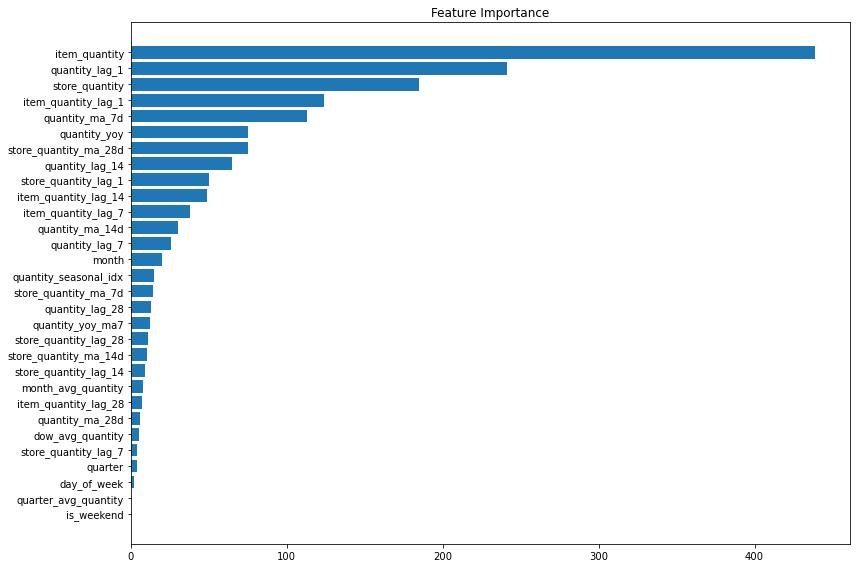

In [88]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
from lightgbm import early_stopping, log_evaluation
from lightgbm import LGBMRegressor

def train_and_evaluate_model(bronze: pd.DataFrame, target_col: str = 'quantity', exclude_cols: list = None):
    """
    Trains and evaluates a LightGBM model for demand forecasting.
    
    Args:
        bronze (pd.DataFrame): The preprocessed dataframe containing the data.
        target_col (str): The name of the target column. Default is 'quantity'.
        exclude_cols (list): List of columns to exclude from training. Default is None, which excludes common columns.
    
    Returns:
        None: Prints model evaluation results and displays feature importance plot.
    """
    # Default columns to exclude if none are provided
    if exclude_cols is None:
        exclude_cols = [
            'item_id', 'store_id', 'quantity', 'date'
        ]
    
    # # Convert object columns to category dtype
    # for col in ['source', 'doc_id', 'subclass_name']:  
    #     bronze[col] = bronze[col].astype('category')

    # Get feature columns
    feature_cols = [col for col in bronze.columns if col not in exclude_cols]
    
     # Handle missing values in features
    for col in feature_cols:
        if bronze[col].dtype in ['int64', 'float64']:  # Only for numeric columns
            bronze[col] = bronze[col].fillna(bronze[col].median())

    # Set up time-based validation
    cutoff_date = bronze['date'].max() - pd.Timedelta(days=28)  # Use last 28 days as validation
    train_data = bronze[bronze['date'] <= cutoff_date]
    valid_data = bronze[bronze['date'] > cutoff_date]

    X_train = train_data[feature_cols]
    y_train = train_data[target_col]
    X_valid = valid_data[feature_cols]
    y_valid = valid_data[target_col]

    # Create LightGBM datasets
    train_dataset = lgb.Dataset(X_train, label=y_train)
    valid_dataset = lgb.Dataset(X_valid, label=y_valid, reference=train_dataset)

    # Set LightGBM parametersaaa
    params = {
        'boosting_type': 'gbdt',
        'objective': 'regression',
        'metric': 'rmse',
        'num_leaves': 31,
        'learning_rate': 0.05,
        'feature_fraction': 0.9,
        'bagging_fraction': 0.8,
        'bagging_freq': 5,
        'verbose': 1
    }
    
    # Train the model using sklearn API (more version-stable)
    model_sklearn = LGBMRegressor(
        objective='regression',
        metric='rmse',
        num_leaves=31,
        learning_rate=0.05,
        feature_fraction=0.9,
        bagging_fraction=0.8,
        bagging_freq=5,
        n_estimators=1000
    )

    # Fit with early stopping
    model_sklearn.fit(
        X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        eval_metric='rmse',
        callbacks=[early_stopping(50), log_evaluation(50)]  # Controls verbosity
    )

    # Make predictions
    y_pred = model_sklearn.predict(X_valid)

    # Evaluate model performance
    rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
    mae = mean_absolute_error(y_valid, y_pred)

    print(f"Validation RMSE: {rmse:.4f}")
    print(f"Validation MAE: {mae:.4f}")

    # Feature importance analysis
    plt.figure(figsize=(12, 8))
    feature_importance = model_sklearn.feature_importances_
    feature_names = model_sklearn.feature_name_

    # Sort features by importance
    sorted_idx = np.argsort(feature_importance)
    plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx])
    plt.yticks(range(len(sorted_idx)), [feature_cols[i] for i in sorted_idx])
    plt.title('Feature Importance')
    plt.tight_layout()
    plt.show()

# Example usage:
train_and_evaluate_model(train_features)


In [89]:
test_features.columns

Index(['item_id', 'quantity', 'store_id', 'date', 'store_quantity',
       'item_quantity', 'day_of_week', 'is_weekend', 'month', 'quarter',
       'quantity_lag_1', 'store_quantity_lag_1', 'item_quantity_lag_1',
       'quantity_lag_7', 'store_quantity_lag_7', 'item_quantity_lag_7',
       'quantity_lag_14', 'store_quantity_lag_14', 'item_quantity_lag_14',
       'quantity_lag_28', 'store_quantity_lag_28', 'item_quantity_lag_28',
       'quantity_ma_7d', 'store_quantity_ma_7d', 'quantity_ma_14d',
       'store_quantity_ma_14d', 'quantity_ma_28d', 'store_quantity_ma_28d',
       'quantity_yoy', 'quantity_yoy_ma7', 'dow_avg_quantity',
       'month_avg_quantity', 'quarter_avg_quantity', 'quantity_seasonal_idx'],
      dtype='object')

In [93]:
test_data.columns

Index(['item_id', 'store_id', 'date', 'quantity'], dtype='object')

In [104]:
def train_and_evaluate_model(
    bronze: pd.DataFrame, 
    test_df: pd.DataFrame,
    target_col: str = 'quantity', 
    exclude_cols: list = None
):
    """
    Trains, evaluates a LightGBM model, and generates test predictions without warnings.
    
    Args:
        bronze (pd.DataFrame): Preprocessed training/validation data.
        test_df (pd.DataFrame): Preprocessed test data.
        target_col (str): Target column name. Default is 'quantity'.
        exclude_cols (list): Columns to exclude from training. Default is None.
    
    Returns:
        pd.DataFrame: Test predictions with 'date', 'item_id', 'store_id', and 'predicted_quantity'.
    """
    # Default columns to exclude
    if exclude_cols is None:
        exclude_cols = ['item_id', 'store_id', 'quantity', 'date']
    
    # Get feature columns
    feature_cols = [col for col in bronze.columns if col not in exclude_cols]
    
    # Handle missing values - avoid SettingWithCopyWarning
    bronze = bronze.copy()  # Explicit copy to avoid warnings
    for col in feature_cols:
        if bronze[col].dtype in ['int64', 'float64']:
            bronze.loc[:, col] = bronze[col].fillna(bronze[col].median())
    
    # Time-based train/validation split
    cutoff_date = bronze['date'].max() - pd.Timedelta(days=28)
    train_data = bronze[bronze['date'] <= cutoff_date].copy()
    valid_data = bronze[bronze['date'] > cutoff_date].copy()

    X_train, y_train = train_data[feature_cols], train_data[target_col]
    X_valid, y_valid = valid_data[feature_cols], valid_data[target_col]

    # Train model
    model = LGBMRegressor(
        objective='regression',
        metric='rmse',
        num_leaves=31,
        learning_rate=0.05,
        n_estimators=1000,
        feature_fraction=0.9,
        bagging_fraction=0.8,
        bagging_freq=5,
        random_state=42,
        force_row_wise=True  # Suppress LightGBM threading warnings
    )
    model.fit(
        X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        callbacks=[early_stopping(50), log_evaluation(50)]
    )

    # Validation metrics
    y_pred_valid = model.predict(X_valid)
    rmse = np.sqrt(mean_squared_error(y_valid, y_pred_valid))
    mae = mean_absolute_error(y_valid, y_pred_valid)
    print(f"Validation RMSE: {rmse:.4f}")
    print(f"Validation MAE: {mae:.4f}")

    # --- Test Predictions ---
    # 1. Ensure test data has the same features
    test_df = test_df.copy()  # Avoid modifying original
    missing_cols = set(feature_cols) - set(test_df.columns)
    for col in missing_cols:
        test_df.loc[:, col] = 0  # Explicit column creation
    
    # 2. Align and fill missing values using training stats
    test_features = test_df[feature_cols].copy()
    for col in feature_cols:
        if test_features[col].dtype in ['int64', 'float64']:
            test_features.loc[:, col] = test_features[col].fillna(bronze[col].median())
    
    # 3. Generate and format predictions
    test_predictions = model.predict(test_features)
    results = pd.DataFrame({
        'row_id': test_df.index,
        'predicted_quantity': test_predictions
    })
    
    # Post-processing
    results['predicted_quantity'] = results['predicted_quantity'].clip(lower=0).round().astype(int)
    
    return results

In [105]:
test_predictions = train_and_evaluate_model(train_features, test_features)

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Info] Total Bins 6652
[LightGBM] [Info] Number of data points in the train set: 1300734, number of used features: 30
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.8,

In [109]:
test_predictions.head(20)

,row_id,predicted_quantity
0,1738122,4
1,1738123,4
2,1738124,4
3,1738125,4
4,1738126,4
5,1738127,4
6,1738128,4
7,1738129,4
8,1738130,4
9,1738131,4


In [108]:
test_predictions.shape

(883680, 2)


# **Demand Forecasting Pipeline with LightGBM**  
*A machine learning pipeline for predicting sales quantities using time-series features and LightGBM.*

## **1. Data Preprocessing**  
- **Input Data**:  
  - Training data (`bronze`): Historical sales records with `item_id`, `store_id`, `date`, and `quantity`.  
  - Test data (`test_df`): Future dates to forecast, with identical feature structure.  

- **Key Steps**:  
  - Sort data chronologically by `(store_id, item_id, date)`.  
  - Handle missing values with **group-wise medians** (avoiding data leakage).  

## **2. Feature Engineering**  
### **Aggregated Features**  
- `store_quantity`: Daily total sales per store.  
- `item_quantity`: Daily total sales per item.  

### **Temporal Features**  
- **Cyclical**: `day_of_week`, `month`, `quarter`, `is_weekend`.  
- **Lags**: `quantity_lag_[1,7,14,28]` (past sales at 1d, 1w, 2w, 4w intervals).  
- **Rolling Aggregations**: `quantity_ma_[7,14,28]d` (7/14/28-day moving averages).  
- **Year-over-Year (YoY)**: `quantity_yoy` (sales from 365 days prior).  
- **Seasonal Indices**: `quantity_seasonal_idx` (monthly deviations from average sales).  

## **3. Model Training**  
- **Algorithm**: LightGBM (`LGBMRegressor`) with RMSE objective.  
- **Hyperparameters**:  
  ```python
  {
      'num_leaves': 31,
      'learning_rate': 0.05,
      'feature_fraction': 0.9,
      'bagging_fraction': 0.8,
      'bagging_freq': 5,
      'early_stopping_rounds': 50
  }
  ```
- **Validation**: Time-based split (last 28 days for validation).  

## **4. Prediction & Output**  
- **Test Data Requirements**:  
  - Must match training feature columns (auto-filled with `0` or medians if missing).  
- **Output Format**:  
  ```python
  {
      'row_id': test_df.index,  # or custom ID column
      'date': test_dates,
      'item_id': item_ids,
      'store_id': store_ids,
      'predicted_quantity': int (clipped ≥ 0)
  }
  ```

## **5. Performance Metrics**  
- **Validation RMSE**: 0.7844  
- **Validation MAE**: 0.5674  

## **Key Considerations**  
- **Data Leakage Prevention**:  
  - All features use `shift()` or `rolling(..).shift(1)` to avoid future data contamination.  
- **Scalability**:  
  - Supports large datasets via LightGBM’s row-wise multi-threading.  


